In [1]:
#Tools
import numpy as np

import tensorflow as tf
from tensorflow import keras
from collections import deque

import GameHard
import DisplayIA

env = GameHard.Game()

%matplotlib inline
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parameters

training_steps = 1000000
batch_size = 64
replay_buffer_size = 100000
min_epsilon = 0.01
input_shape = [15, 2]
n_actions = 3
discount_factor = 0.99
optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
loss_fn = keras.losses.Huber(reduction="none")

#Actions at X steps
evaluate_steps = 20000
train_steps = 4
epsilon_steps = 62500
target_switch = 1000
evaluate_episode = 200

In [3]:
#PER memory
class SumTree(object):
    data_pointer = 0
    
    # Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema below
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
        
        
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        """ tree:
                    0
                   / \
                  0   0
                 / \ / \
        tree_index  0 0  0  We fill the leaves from left to right
        """

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update (tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity:  # If we're above the capacity, we go back to first index (we overwrite)
            self.data_pointer = 0


    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        # this method is faster than the recursive loop
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
            
            
            
    def get_leaf(self, v):
        parent_index = 0

        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: # downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]

    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node 
    
    
class Memory(object):  # stored as ( state, action, reward, next_state ) in SumTree
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        self.tree = SumTree(capacity)
        
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this experience will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the max priority for new priority
    
    
    def sample(self, n):
        # Create a minibatch array that will contains the minibatch
        minibatch = []

        b_idx = np.empty((n,), dtype=np.int32)

        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment

        for i in range(n):
            # A value is uniformly sample from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)

            b_idx[i]= index

            minibatch.append([data[0],data[1],data[2],data[3],data[4]])

        return b_idx, minibatch
    
    
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

In [4]:
# Class for my agent
class YoushiAgent:
    def __init__(self):
        self.current_training_step = 0
        self.total_steps = 0
        
        
        """self.model = keras.models.Sequential([
            keras.layers.Lambda(lambda x: x / 1000.0)(input_shape=input_shape),
            keras.layers.Flatten(),
            keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling()),
            keras.layers.Dense(200, activation="relu", kernel_initializer=keras.initializers.VarianceScaling()),
            keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling()),
            keras.layers.Dense(n_outputs, kernel_initializer=keras.initializers.VarianceScaling())
        ]) """
        
        frames_input = keras.layers.Input(input_shape, name='frames')

        # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
        normalized = keras.layers.Lambda(lambda x: x / 1000.0)(frames_input)

        flatten = keras.layers.Flatten()(normalized)
        dense_1 = keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling())(flatten)
        dense_2 = keras.layers.Dense(200, activation="relu", kernel_initializer=keras.initializers.VarianceScaling())(dense_1)
        dense_3 = keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling())(dense_2)
        # "The output layer is a fully-connected linear layer with a single output for each valid action."
        output = keras.layers.Dense(n_actions)(dense_3)
        self.model = keras.models.Model(inputs=frames_input, outputs=output)
        
        self.target = keras.models.clone_model(self.model)
        self.target.set_weights(self.model.get_weights())
        
        #self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.replay_buffer = Memory(replay_buffer_size)
        
        self.best_average = 0
        self.best_steps = 0
        self.averages = []
    
    def action_random(self, last_state, last_action, state, reward, done):
        #self.replay_buffer.append((last_state, last_action, reward, state, done))
        self.replay_buffer.store((last_state, last_action, reward, state, done))
        action = np.random.randint(n_actions)
        return action
        
    #This methode ask the agent to select an action and train if requiered
    def action_train(self, last_state, last_action, state, reward, done):
        self.total_steps += 1
        
        #self.replay_buffer.append((last_state, last_action, reward, state, done))
        self.replay_buffer.store((last_state, last_action, reward, state, done))        
        
        action = self.epsilon_greedy_policy(state)
        
        if self.total_steps % train_steps == 0:
            self.train()
            self.current_training_step += 1
            
        if self.current_training_step % target_switch == 0:
            self.target.set_weights(self.model.get_weights())
        
        return action
    
    def epsilon_greedy_policy(self, state):
        epsilon = max(1 - (self.current_training_step / epsilon_steps), min_epsilon)
        if np.random.rand() < epsilon:
            return np.random.randint(n_actions)
        else :
            Q_values = self.model.predict(state[np.newaxis])
            return np.argmax(Q_values[0])
        
    def train(self):
        #states, actions, rewards, next_states, dones = self.sample_experiences()
        tree_idx, minibatch = self.replay_buffer.sample(64)
        
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        for value in minibatch :
            states.append(value[0])
            actions.append(value[1])
            rewards.append(value[2])
            next_states.append(value[3])
            dones.append(value[4])
        
        states = np.asarray(states)
        actions = np.asarray(actions)
        rewards = np.asarray(rewards)
        next_states = np.asarray(next_states)
        dones = np.asarray(dones)
        
        next_Q_values = self.model.predict(next_states)
        best_next_actions = np.argmax(next_Q_values[0])
        next_mask = tf.one_hot(best_next_actions, n_actions).numpy()
        next_best_Q_values = (self.target.predict(next_states) * next_mask).sum(axis=1)
        target_Q_values = rewards + (1 - dones) * discount_factor * next_best_Q_values
        mask = tf.one_hot(actions, n_actions)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
            
            absolute_errors = np.mean(np.abs(target_Q_values - Q_values), axis=1)
            self.replay_buffer.batch_update(tree_idx, absolute_errors)
            
        grads = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_buffer), size=batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        return states, actions, rewards, next_states, dones
    
    def test_save(self):
        print("test_save")
        scores = 0
        for i in range(evaluate_episode):
            score = self.play_game()
            scores += score
        
        average = scores / evaluate_episode
        self.averages.append(average)
        if average > self.best_average :
            self.best_average = average
            self.best_steps = self.current_training_step
            self.model.save('myDQL.h5')
            print("Best agent saved, score : " + str(average))
        print("test_save finished")
            
    def play_game(self):
        playenv = GameHard.Game()
        
        state = playenv.reset()
        done = False
        
        steps = 0
        
        while not done:
            Q_values = self.model.predict(state[np.newaxis])
            action = np.argmax(Q_values[0])
            state, reward, done, _ = playenv.step(action)
            steps += 1
        
        return steps
    
    def print_data(self):
        print("Best agent score : " + str(self.best_average))
        print("Best agent step : " + str(self.best_steps))
        print("total step : " + str(self.total_steps))
        plt.plot(self.averages)
        plt.show()

agent = YoushiAgent()

In [5]:
#Play a few random
state = env.reset()
last_state = state
last_action = 0
done = False
reward = 0

for i in range(100000):
    action = agent.action_random(last_state, last_action, state, reward, done)
    last_action = action
    last_state = state
    
    if not done:
        state, reward, done, _ = env.step(action)
    else :
        state = env.reset()
        reward = 0
        done = False
        
    if i % 10000 == 0:
        print("Step : " + str(i))

Step : 0
Step : 10000
Step : 20000
Step : 30000
Step : 40000
Step : 50000
Step : 60000
Step : 70000
Step : 80000
Step : 90000



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Training step : 250
Training step : 500
Training step : 750
Training step : 1000
Training step : 1250
Training step : 1500
Training step : 1750
Training step : 2000
Training step : 2250
Training step : 2500
Best agent score : 0
Best agent step : 0
total step : 10000


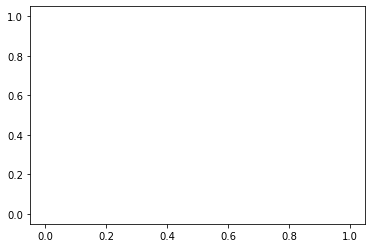

Training step : 2750
Training step : 3000
Training step : 3250
Training step : 3500
Training step : 3750
Training step : 4000
Training step : 4250
Training step : 4500
Training step : 4750
Training step : 5000
Best agent score : 0
Best agent step : 0
total step : 20000


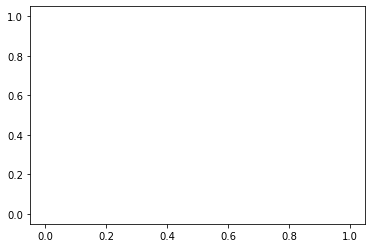

Training step : 5250
Training step : 5500
Training step : 5750
Training step : 6000
Training step : 6250
Training step : 6500
Training step : 6750
Training step : 7000
Training step : 7250
Training step : 7500
Best agent score : 0
Best agent step : 0
total step : 30000


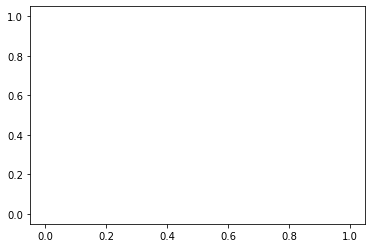

Training step : 7750
Training step : 8000
Training step : 8250
Training step : 8500
Training step : 8750
Training step : 9000
Training step : 9250
Training step : 9500
Training step : 9750
Training step : 10000
Best agent score : 0
Best agent step : 0
total step : 40000


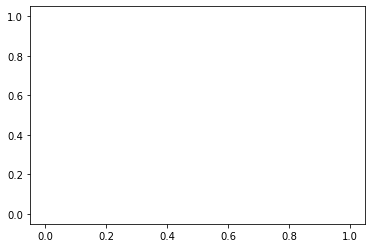

Training step : 10250
Training step : 10500
Training step : 10750
Training step : 11000
Training step : 11250
Training step : 11500
Training step : 11750
Training step : 12000
Training step : 12250
Training step : 12500
Best agent score : 0
Best agent step : 0
total step : 50000


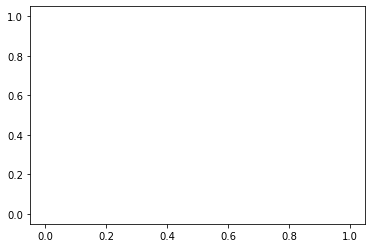

Training step : 12750
Training step : 13000
Training step : 13250
Training step : 13500
Training step : 13750
Training step : 14000
Training step : 14250
Training step : 14500
Training step : 14750
Training step : 15000
Best agent score : 0
Best agent step : 0
total step : 60000


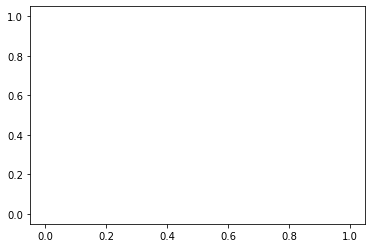

Training step : 15250
Training step : 15500
Training step : 15750
Training step : 16000
Training step : 16250
Training step : 16500
Training step : 16750
Training step : 17000
Training step : 17250
Training step : 17500
Best agent score : 0
Best agent step : 0
total step : 70000


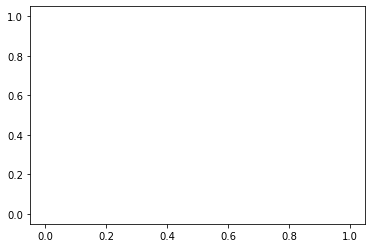

Training step : 17750
Training step : 18000
Training step : 18250
Training step : 18500
Training step : 18750
Training step : 19000
Training step : 19250
Training step : 19500
Training step : 19750
test_save
Best agent saved, score : 116.88
test_save finished
Training step : 20000
Best agent score : 116.88
Best agent step : 20000
total step : 80000


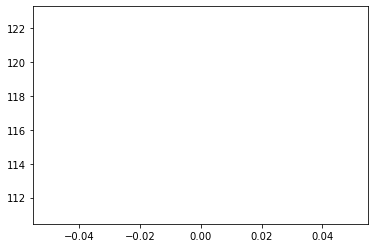

Training step : 20250
Training step : 20500
Training step : 20750
Training step : 21000
Training step : 21250
Training step : 21500
Training step : 21750
Training step : 22000
Training step : 22250
Training step : 22500
Best agent score : 116.88
Best agent step : 20000
total step : 90000


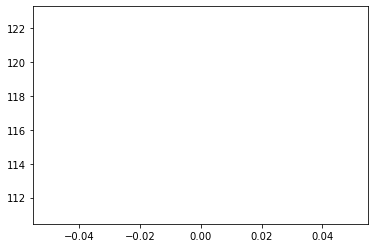

Training step : 22750
Training step : 23000
Training step : 23250
Training step : 23500
Training step : 23750
Training step : 24000
Training step : 24250
Training step : 24500
Training step : 24750
Training step : 25000
Best agent score : 116.88
Best agent step : 20000
total step : 100000


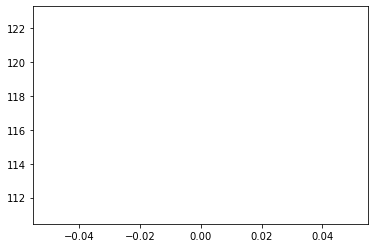

Training step : 25250
Training step : 25500
Training step : 25750
Training step : 26000
Training step : 26250
Training step : 26500
Training step : 26750
Training step : 27000
Training step : 27250
Training step : 27500
Best agent score : 116.88
Best agent step : 20000
total step : 110000


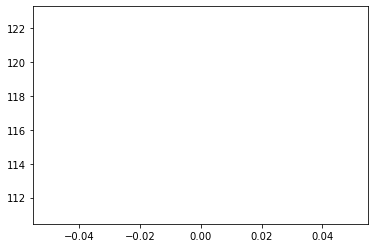

Training step : 27750
Training step : 28000
Training step : 28250
Training step : 28500
Training step : 28750
Training step : 29000
Training step : 29250
Training step : 29500
Training step : 29750
Training step : 30000
Best agent score : 116.88
Best agent step : 20000
total step : 120000


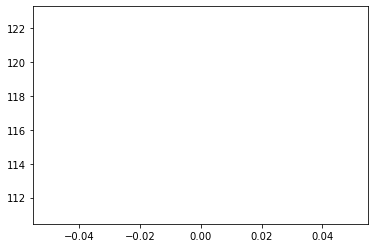

Training step : 30250
Training step : 30500
Training step : 30750
Training step : 31000
Training step : 31250
Training step : 31500
Training step : 31750
Training step : 32000
Training step : 32250
Training step : 32500
Best agent score : 116.88
Best agent step : 20000
total step : 130000


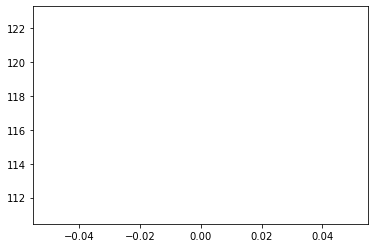

Training step : 32750
Training step : 33000
Training step : 33250
Training step : 33500
Training step : 33750
Training step : 34000
Training step : 34250
Training step : 34500
Training step : 34750
Training step : 35000
Best agent score : 116.88
Best agent step : 20000
total step : 140000


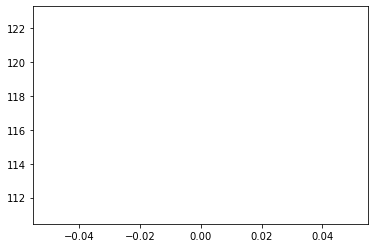

Training step : 35250
Training step : 35500
Training step : 35750
Training step : 36000
Training step : 36250
Training step : 36500
Training step : 36750
Training step : 37000
Training step : 37250
Training step : 37500
Best agent score : 116.88
Best agent step : 20000
total step : 150000


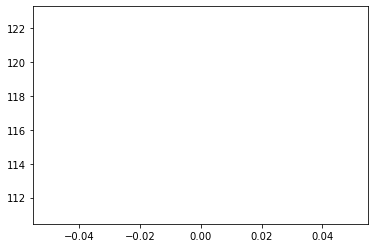

Training step : 37750
Training step : 38000
Training step : 38250
Training step : 38500
Training step : 38750
Training step : 39000
Training step : 39250
Training step : 39500
Training step : 39750
test_save
test_save finished
Training step : 40000
Best agent score : 116.88
Best agent step : 20000
total step : 160000


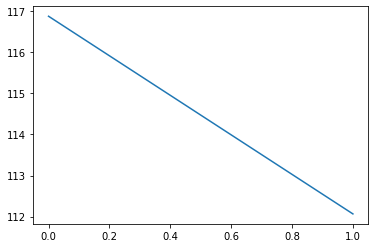

Training step : 40250
Training step : 40500
Training step : 40750
Training step : 41000
Training step : 41250
Training step : 41500
Training step : 41750
Training step : 42000
Training step : 42250
Training step : 42500
Best agent score : 116.88
Best agent step : 20000
total step : 170000


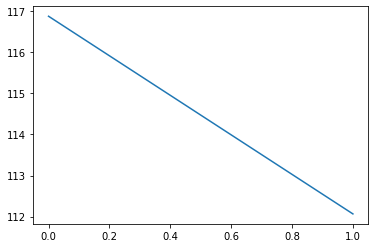

Training step : 42750
Training step : 43000
Training step : 43250
Training step : 43500
Training step : 43750
Training step : 44000
Training step : 44250
Training step : 44500
Training step : 44750
Training step : 45000
Best agent score : 116.88
Best agent step : 20000
total step : 180000


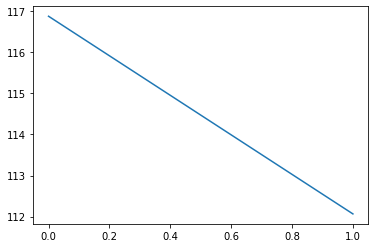

Training step : 45250
Training step : 45500
Training step : 45750
Training step : 46000
Training step : 46250
Training step : 46500
Training step : 46750
Training step : 47000
Training step : 47250
Training step : 47500
Best agent score : 116.88
Best agent step : 20000
total step : 190000


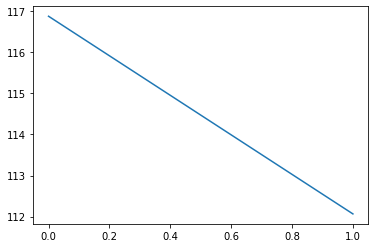

Training step : 47750
Training step : 48000
Training step : 48250
Training step : 48500
Training step : 48750
Training step : 49000
Training step : 49250
Training step : 49500
Training step : 49750
Training step : 50000
Best agent score : 116.88
Best agent step : 20000
total step : 200000


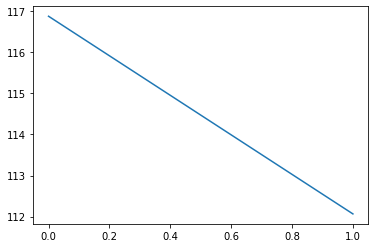

Training step : 50250
Training step : 50500
Training step : 50750
Training step : 51000
Training step : 51250
Training step : 51500
Training step : 51750
Training step : 52000
Training step : 52250
Training step : 52500
Best agent score : 116.88
Best agent step : 20000
total step : 210000


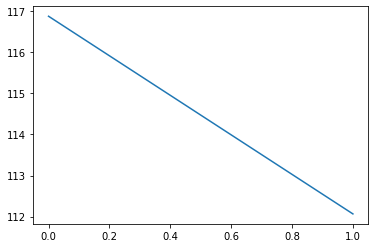

Training step : 52750
Training step : 53000
Training step : 53250
Training step : 53500
Training step : 53750
Training step : 54000
Training step : 54250
Training step : 54500
Training step : 54750
Training step : 55000
Best agent score : 116.88
Best agent step : 20000
total step : 220000


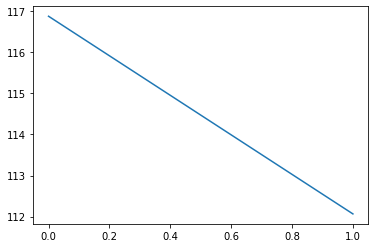

Training step : 55250
Training step : 55500
Training step : 55750
Training step : 56000
Training step : 56250
Training step : 56500
Training step : 56750
Training step : 57000
Training step : 57250
Training step : 57500
Best agent score : 116.88
Best agent step : 20000
total step : 230000


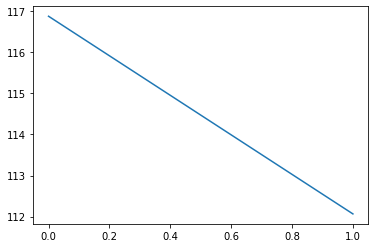

Training step : 57750
Training step : 58000
Training step : 58250
Training step : 58500
Training step : 58750
Training step : 59000
Training step : 59250
Training step : 59500
Training step : 59750
test_save
Best agent saved, score : 119.065
test_save finished
Training step : 60000
Best agent score : 119.065
Best agent step : 60000
total step : 240000


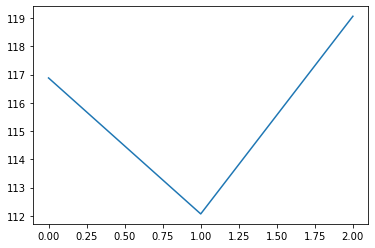

Training step : 60250
Training step : 60500
Training step : 60750
Training step : 61000
Training step : 61250
Training step : 61500
Training step : 61750
Training step : 62000
Training step : 62250
Training step : 62500
Best agent score : 119.065
Best agent step : 60000
total step : 250000


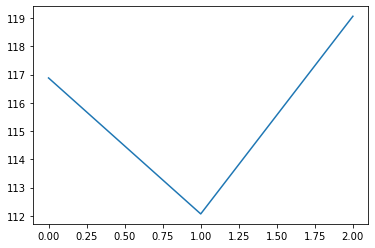

Training step : 62750
Training step : 63000
Training step : 63250
Training step : 63500
Training step : 63750
Training step : 64000
Training step : 64250
Training step : 64500
Training step : 64750
Training step : 65000
Best agent score : 119.065
Best agent step : 60000
total step : 260000


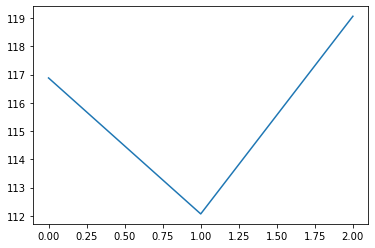

Training step : 65250
Training step : 65500
Training step : 65750
Training step : 66000
Training step : 66250
Training step : 66500
Training step : 66750
Training step : 67000
Training step : 67250
Training step : 67500
Best agent score : 119.065
Best agent step : 60000
total step : 270000


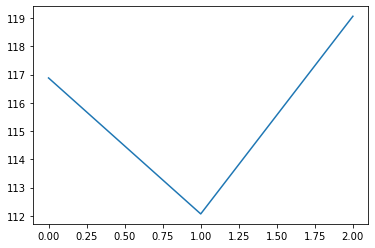

Training step : 67750
Training step : 68000
Training step : 68250
Training step : 68500
Training step : 68750
Training step : 69000
Training step : 69250
Training step : 69500
Training step : 69750
Training step : 70000
Best agent score : 119.065
Best agent step : 60000
total step : 280000


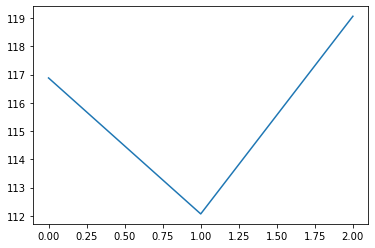

Training step : 70250
Training step : 70500
Training step : 70750
Training step : 71000
Training step : 71250
Training step : 71500
Training step : 71750
Training step : 72000
Training step : 72250
Training step : 72500
Best agent score : 119.065
Best agent step : 60000
total step : 290000


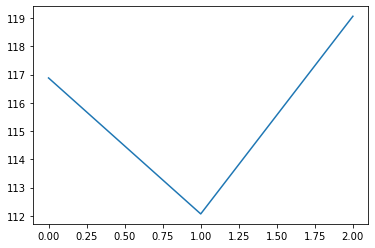

Training step : 72750
Training step : 73000
Training step : 73250
Training step : 73500
Training step : 73750
Training step : 74000
Training step : 74250
Training step : 74500
Training step : 74750
Training step : 75000
Best agent score : 119.065
Best agent step : 60000
total step : 300000


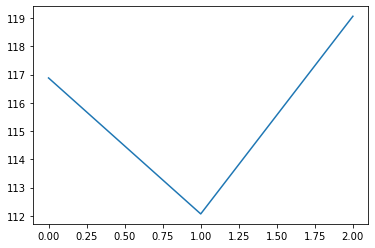

Training step : 75250
Training step : 75500
Training step : 75750
Training step : 76000
Training step : 76250
Training step : 76500
Training step : 76750
Training step : 77000
Training step : 77250
Training step : 77500
Best agent score : 119.065
Best agent step : 60000
total step : 310000


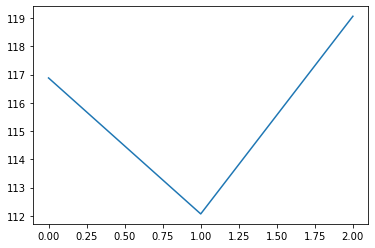

Training step : 77750
Training step : 78000
Training step : 78250
Training step : 78500
Training step : 78750
Training step : 79000
Training step : 79250
Training step : 79500
Training step : 79750
test_save
Best agent saved, score : 119.41
test_save finished
Training step : 80000
Best agent score : 119.41
Best agent step : 80000
total step : 320000


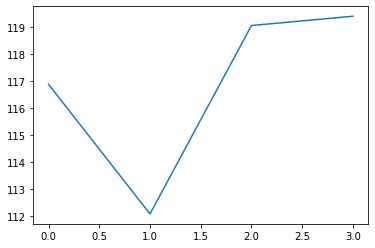

Training step : 80250
Training step : 80500
Training step : 80750
Training step : 81000
Training step : 81250
Training step : 81500
Training step : 81750
Training step : 82000
Training step : 82250
Training step : 82500
Best agent score : 119.41
Best agent step : 80000
total step : 330000


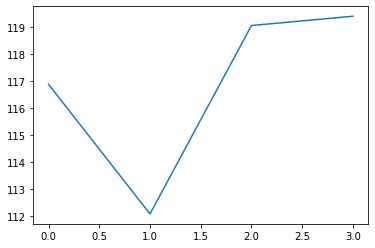

Training step : 82750
Training step : 83000
Training step : 83250
Training step : 83500
Training step : 83750
Training step : 84000
Training step : 84250
Training step : 84500
Training step : 84750
Training step : 85000
Best agent score : 119.41
Best agent step : 80000
total step : 340000


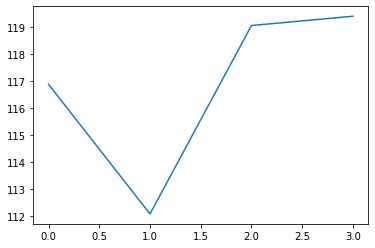

Training step : 85250
Training step : 85500
Training step : 85750
Training step : 86000
Training step : 86250
Training step : 86500
Training step : 86750
Training step : 87000
Training step : 87250
Training step : 87500
Best agent score : 119.41
Best agent step : 80000
total step : 350000


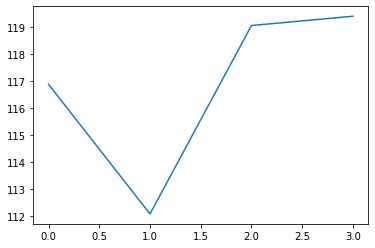

Training step : 87750
Training step : 88000
Training step : 88250
Training step : 88500
Training step : 88750
Training step : 89000
Training step : 89250
Training step : 89500
Training step : 89750
Training step : 90000
Best agent score : 119.41
Best agent step : 80000
total step : 360000


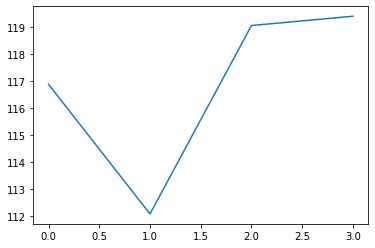

Training step : 90250
Training step : 90500
Training step : 90750
Training step : 91000
Training step : 91250
Training step : 91500
Training step : 91750
Training step : 92000
Training step : 92250
Training step : 92500
Best agent score : 119.41
Best agent step : 80000
total step : 370000


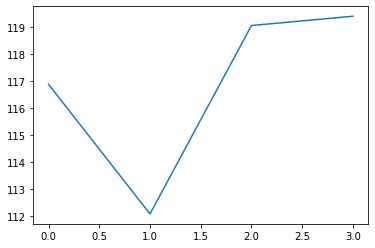

Training step : 92750
Training step : 93000
Training step : 93250
Training step : 93500
Training step : 93750
Training step : 94000
Training step : 94250
Training step : 94500
Training step : 94750
Training step : 95000
Best agent score : 119.41
Best agent step : 80000
total step : 380000


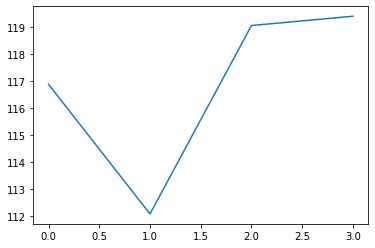

Training step : 95250
Training step : 95500
Training step : 95750
Training step : 96000
Training step : 96250
Training step : 96500
Training step : 96750
Training step : 97000
Training step : 97250
Training step : 97500
Best agent score : 119.41
Best agent step : 80000
total step : 390000


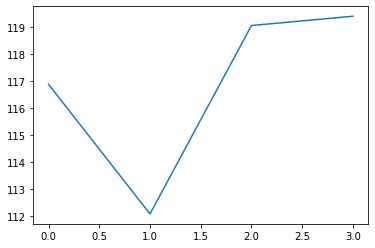

Training step : 97750
Training step : 98000
Training step : 98250
Training step : 98500
Training step : 98750
Training step : 99000
Training step : 99250
Training step : 99500
Training step : 99750
test_save
Best agent saved, score : 270.355
test_save finished
Training step : 100000
Best agent score : 270.355
Best agent step : 100000
total step : 400000


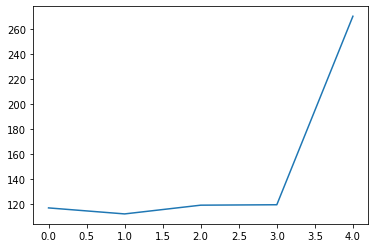

Training step : 100250
Training step : 100500
Training step : 100750
Training step : 101000
Training step : 101250
Training step : 101500
Training step : 101750
Training step : 102000
Training step : 102250
Training step : 102500
Best agent score : 270.355
Best agent step : 100000
total step : 410000


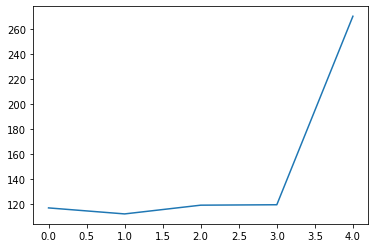

Training step : 102750
Training step : 103000
Training step : 103250
Training step : 103500
Training step : 103750
Training step : 104000
Training step : 104250
Training step : 104500
Training step : 104750
Training step : 105000
Best agent score : 270.355
Best agent step : 100000
total step : 420000


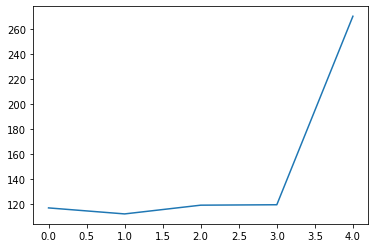

Training step : 105250
Training step : 105500
Training step : 105750
Training step : 106000
Training step : 106250
Training step : 106500
Training step : 106750
Training step : 107000
Training step : 107250
Training step : 107500
Best agent score : 270.355
Best agent step : 100000
total step : 430000


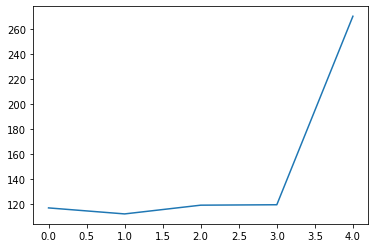

Training step : 107750
Training step : 108000
Training step : 108250
Training step : 108500
Training step : 108750
Training step : 109000
Training step : 109250
Training step : 109500
Training step : 109750
Training step : 110000
Best agent score : 270.355
Best agent step : 100000
total step : 440000


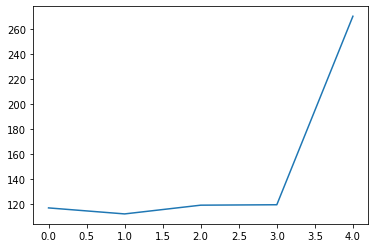

Training step : 110250
Training step : 110500
Training step : 110750
Training step : 111000
Training step : 111250
Training step : 111500
Training step : 111750
Training step : 112000
Training step : 112250
Training step : 112500
Best agent score : 270.355
Best agent step : 100000
total step : 450000


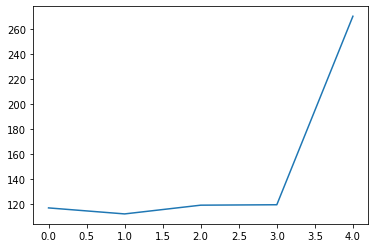

Training step : 112750
Training step : 113000
Training step : 113250
Training step : 113500
Training step : 113750
Training step : 114000
Training step : 114250
Training step : 114500
Training step : 114750
Training step : 115000
Best agent score : 270.355
Best agent step : 100000
total step : 460000


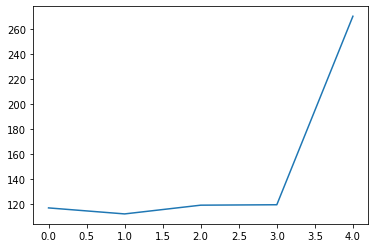

Training step : 115250
Training step : 115500
Training step : 115750
Training step : 116000
Training step : 116250
Training step : 116500
Training step : 116750
Training step : 117000
Training step : 117250
Training step : 117500
Best agent score : 270.355
Best agent step : 100000
total step : 470000


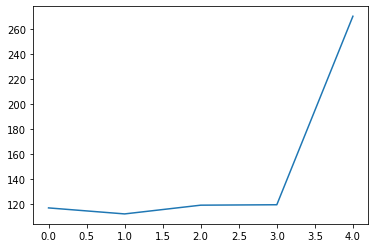

Training step : 117750
Training step : 118000
Training step : 118250
Training step : 118500
Training step : 118750
Training step : 119000
Training step : 119250
Training step : 119500
Training step : 119750
test_save
test_save finished
Training step : 120000
Best agent score : 270.355
Best agent step : 100000
total step : 480000


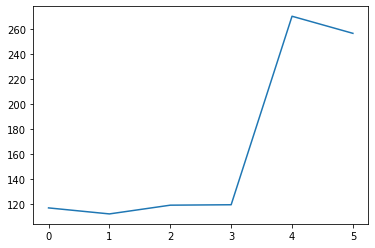

Training step : 120250
Training step : 120500
Training step : 120750
Training step : 121000
Training step : 121250
Training step : 121500
Training step : 121750
Training step : 122000
Training step : 122250
Training step : 122500
Best agent score : 270.355
Best agent step : 100000
total step : 490000


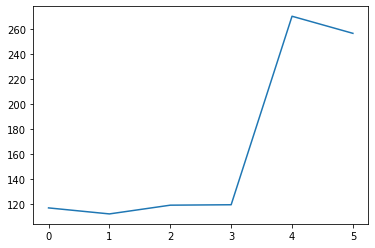

Training step : 122750
Training step : 123000
Training step : 123250
Training step : 123500
Training step : 123750
Training step : 124000
Training step : 124250
Training step : 124500
Training step : 124750
Training step : 125000
Best agent score : 270.355
Best agent step : 100000
total step : 500000


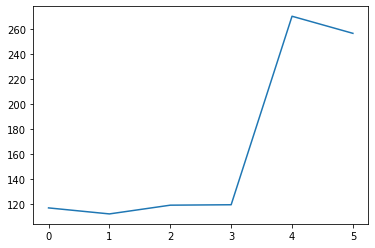

Training step : 125250
Training step : 125500
Training step : 125750
Training step : 126000
Training step : 126250
Training step : 126500
Training step : 126750
Training step : 127000
Training step : 127250
Training step : 127500
Best agent score : 270.355
Best agent step : 100000
total step : 510000


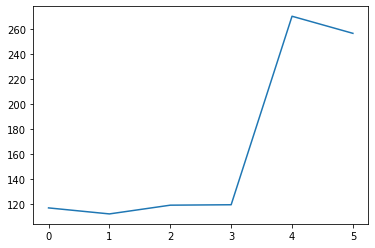

Training step : 127750
Training step : 128000
Training step : 128250
Training step : 128500
Training step : 128750
Training step : 129000
Training step : 129250
Training step : 129500
Training step : 129750
Training step : 130000
Best agent score : 270.355
Best agent step : 100000
total step : 520000


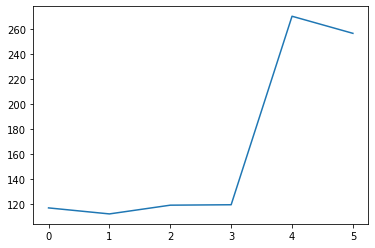

Training step : 130250
Training step : 130500
Training step : 130750
Training step : 131000
Training step : 131250
Training step : 131500
Training step : 131750
Training step : 132000
Training step : 132250
Training step : 132500
Best agent score : 270.355
Best agent step : 100000
total step : 530000


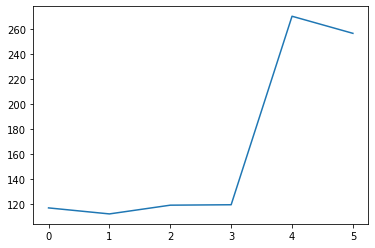

Training step : 132750
Training step : 133000
Training step : 133250
Training step : 133500
Training step : 133750
Training step : 134000
Training step : 134250
Training step : 134500
Training step : 134750
Training step : 135000
Best agent score : 270.355
Best agent step : 100000
total step : 540000


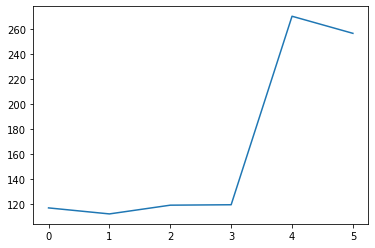

Training step : 135250
Training step : 135500
Training step : 135750
Training step : 136000
Training step : 136250
Training step : 136500
Training step : 136750
Training step : 137000
Training step : 137250
Training step : 137500
Best agent score : 270.355
Best agent step : 100000
total step : 550000


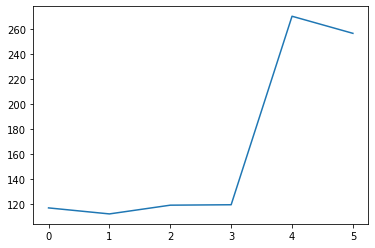

Training step : 137750
Training step : 138000
Training step : 138250
Training step : 138500
Training step : 138750
Training step : 139000
Training step : 139250
Training step : 139500
Training step : 139750
test_save
test_save finished
Training step : 140000
Best agent score : 270.355
Best agent step : 100000
total step : 560000


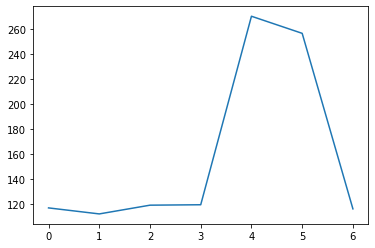

Training step : 140250
Training step : 140500
Training step : 140750
Training step : 141000
Training step : 141250
Training step : 141500
Training step : 141750
Training step : 142000
Training step : 142250
Training step : 142500
Best agent score : 270.355
Best agent step : 100000
total step : 570000


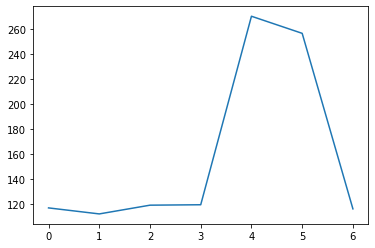

Training step : 142750
Training step : 143000
Training step : 143250
Training step : 143500
Training step : 143750
Training step : 144000
Training step : 144250
Training step : 144500
Training step : 144750
Training step : 145000
Best agent score : 270.355
Best agent step : 100000
total step : 580000


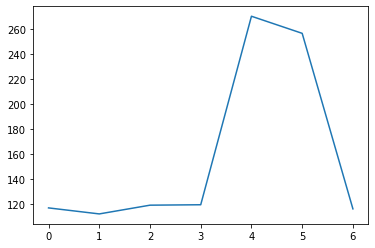

Training step : 145250
Training step : 145500
Training step : 145750
Training step : 146000
Training step : 146250
Training step : 146500
Training step : 146750
Training step : 147000
Training step : 147250
Training step : 147500
Best agent score : 270.355
Best agent step : 100000
total step : 590000


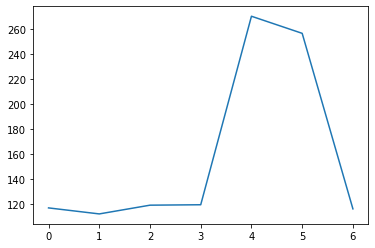

Training step : 147750
Training step : 148000
Training step : 148250
Training step : 148500
Training step : 148750
Training step : 149000
Training step : 149250
Training step : 149500
Training step : 149750
Training step : 150000
Best agent score : 270.355
Best agent step : 100000
total step : 600000


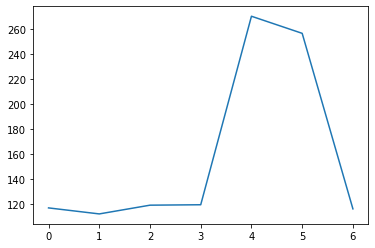

Training step : 150250
Training step : 150500
Training step : 150750
Training step : 151000
Training step : 151250
Training step : 151500
Training step : 151750
Training step : 152000
Training step : 152250
Training step : 152500
Best agent score : 270.355
Best agent step : 100000
total step : 610000


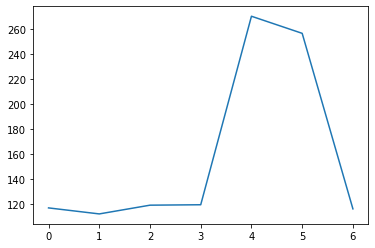

Training step : 152750
Training step : 153000
Training step : 153250
Training step : 153500
Training step : 153750
Training step : 154000
Training step : 154250
Training step : 154500
Training step : 154750
Training step : 155000
Best agent score : 270.355
Best agent step : 100000
total step : 620000


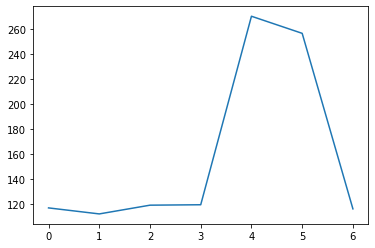

Training step : 155250
Training step : 155500
Training step : 155750
Training step : 156000
Training step : 156250
Training step : 156500
Training step : 156750
Training step : 157000
Training step : 157250
Training step : 157500
Best agent score : 270.355
Best agent step : 100000
total step : 630000


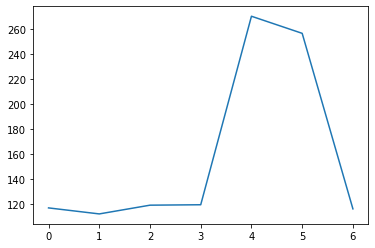

Training step : 157750
Training step : 158000
Training step : 158250
Training step : 158500
Training step : 158750
Training step : 159000
Training step : 159250
Training step : 159500
Training step : 159750
test_save
test_save finished
Training step : 160000
Best agent score : 270.355
Best agent step : 100000
total step : 640000


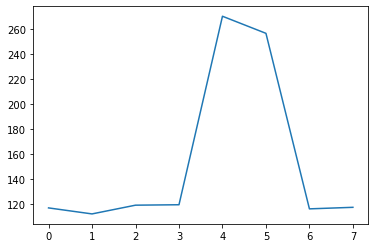

Training step : 160250
Training step : 160500
Training step : 160750
Training step : 161000
Training step : 161250
Training step : 161500
Training step : 161750
Training step : 162000
Training step : 162250
Training step : 162500
Best agent score : 270.355
Best agent step : 100000
total step : 650000


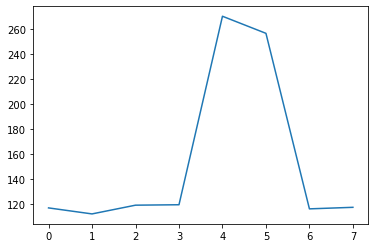

Training step : 162750
Training step : 163000
Training step : 163250
Training step : 163500
Training step : 163750
Training step : 164000
Training step : 164250
Training step : 164500
Training step : 164750
Training step : 165000
Best agent score : 270.355
Best agent step : 100000
total step : 660000


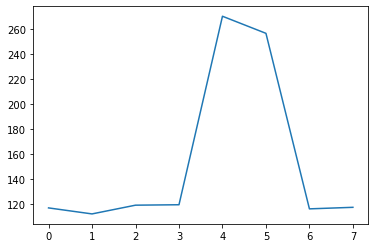

Training step : 165250
Training step : 165500
Training step : 165750
Training step : 166000
Training step : 166250
Training step : 166500
Training step : 166750
Training step : 167000
Training step : 167250
Training step : 167500
Best agent score : 270.355
Best agent step : 100000
total step : 670000


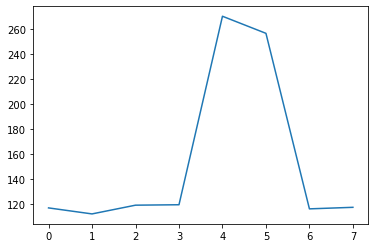

Training step : 167750
Training step : 168000
Training step : 168250
Training step : 168500
Training step : 168750
Training step : 169000
Training step : 169250
Training step : 169500
Training step : 169750
Training step : 170000
Best agent score : 270.355
Best agent step : 100000
total step : 680000


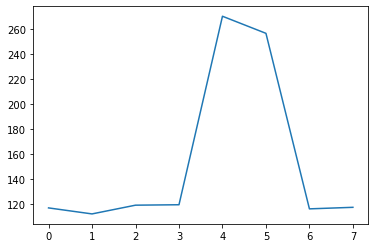

Training step : 170250
Training step : 170500
Training step : 170750
Training step : 171000
Training step : 171250
Training step : 171500
Training step : 171750
Training step : 172000
Training step : 172250
Training step : 172500
Best agent score : 270.355
Best agent step : 100000
total step : 690000


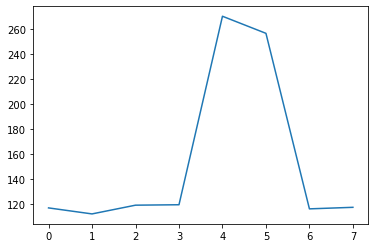

Training step : 172750
Training step : 173000
Training step : 173250
Training step : 173500
Training step : 173750
Training step : 174000
Training step : 174250
Training step : 174500
Training step : 174750
Training step : 175000
Best agent score : 270.355
Best agent step : 100000
total step : 700000


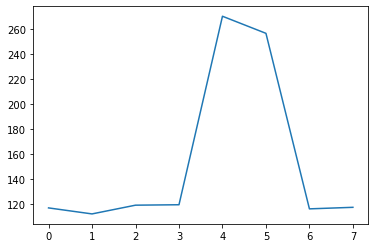

Training step : 175250
Training step : 175500
Training step : 175750
Training step : 176000
Training step : 176250
Training step : 176500
Training step : 176750
Training step : 177000
Training step : 177250
Training step : 177500
Best agent score : 270.355
Best agent step : 100000
total step : 710000


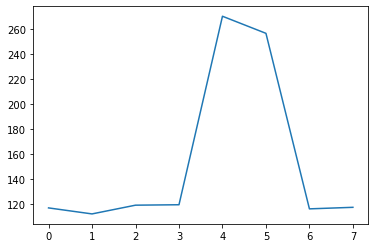

Training step : 177750
Training step : 178000
Training step : 178250
Training step : 178500
Training step : 178750
Training step : 179000
Training step : 179250
Training step : 179500
Training step : 179750
test_save
test_save finished
Training step : 180000
Best agent score : 270.355
Best agent step : 100000
total step : 720000


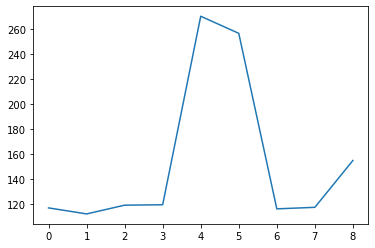

Training step : 180250
Training step : 180500
Training step : 180750
Training step : 181000
Training step : 181250
Training step : 181500
Training step : 181750
Training step : 182000
Training step : 182250
Training step : 182500
Best agent score : 270.355
Best agent step : 100000
total step : 730000


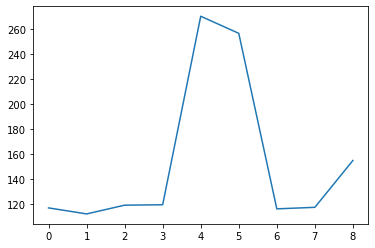

Training step : 182750
Training step : 183000
Training step : 183250
Training step : 183500
Training step : 183750
Training step : 184000
Training step : 184250
Training step : 184500
Training step : 184750
Training step : 185000
Best agent score : 270.355
Best agent step : 100000
total step : 740000


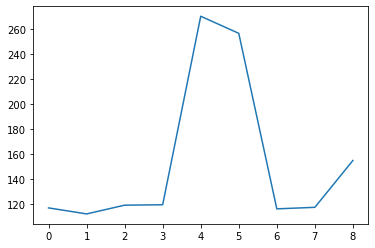

Training step : 185250
Training step : 185500
Training step : 185750
Training step : 186000
Training step : 186250
Training step : 186500
Training step : 186750
Training step : 187000
Training step : 187250
Training step : 187500
Best agent score : 270.355
Best agent step : 100000
total step : 750000


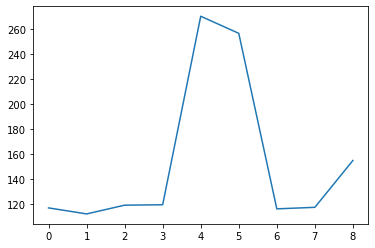

Training step : 187750
Training step : 188000
Training step : 188250
Training step : 188500
Training step : 188750
Training step : 189000
Training step : 189250
Training step : 189500
Training step : 189750
Training step : 190000
Best agent score : 270.355
Best agent step : 100000
total step : 760000


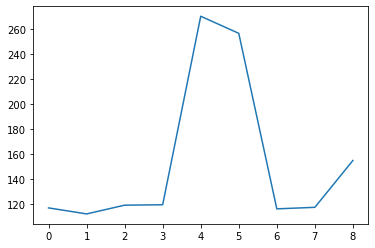

Training step : 190250
Training step : 190500
Training step : 190750
Training step : 191000
Training step : 191250
Training step : 191500
Training step : 191750
Training step : 192000
Training step : 192250
Training step : 192500
Best agent score : 270.355
Best agent step : 100000
total step : 770000


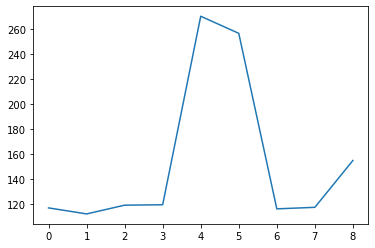

Training step : 192750
Training step : 193000
Training step : 193250
Training step : 193500
Training step : 193750
Training step : 194000
Training step : 194250
Training step : 194500
Training step : 194750
Training step : 195000
Best agent score : 270.355
Best agent step : 100000
total step : 780000


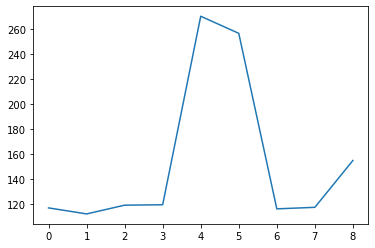

Training step : 195250
Training step : 195500
Training step : 195750
Training step : 196000
Training step : 196250
Training step : 196500
Training step : 196750
Training step : 197000
Training step : 197250
Training step : 197500
Best agent score : 270.355
Best agent step : 100000
total step : 790000


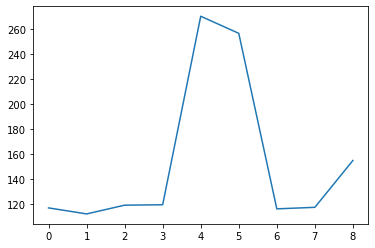

Training step : 197750
Training step : 198000
Training step : 198250
Training step : 198500
Training step : 198750
Training step : 199000
Training step : 199250
Training step : 199500
Training step : 199750
test_save
test_save finished
Training step : 200000
Best agent score : 270.355
Best agent step : 100000
total step : 800000


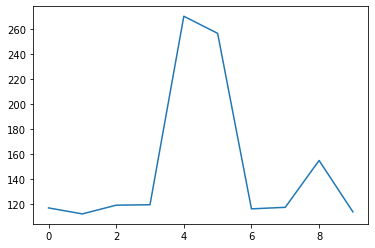

Training step : 200250
Training step : 200500
Training step : 200750
Training step : 201000
Training step : 201250
Training step : 201500
Training step : 201750
Training step : 202000
Training step : 202250
Training step : 202500
Best agent score : 270.355
Best agent step : 100000
total step : 810000


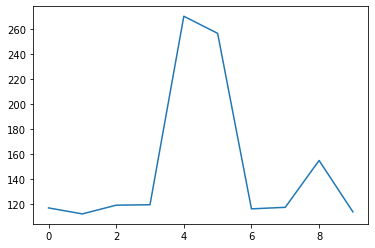

Training step : 202750
Training step : 203000
Training step : 203250
Training step : 203500
Training step : 203750
Training step : 204000
Training step : 204250
Training step : 204500
Training step : 204750
Training step : 205000
Best agent score : 270.355
Best agent step : 100000
total step : 820000


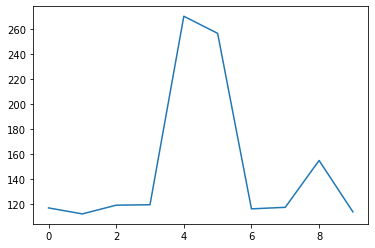

Training step : 205250
Training step : 205500
Training step : 205750
Training step : 206000
Training step : 206250
Training step : 206500
Training step : 206750
Training step : 207000
Training step : 207250
Training step : 207500
Best agent score : 270.355
Best agent step : 100000
total step : 830000


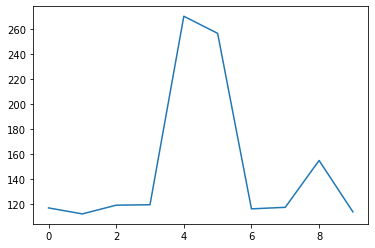

Training step : 207750
Training step : 208000
Training step : 208250
Training step : 208500
Training step : 208750
Training step : 209000
Training step : 209250
Training step : 209500
Training step : 209750
Training step : 210000
Best agent score : 270.355
Best agent step : 100000
total step : 840000


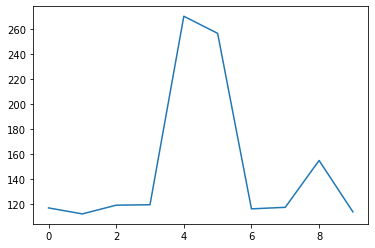

Training step : 210250
Training step : 210500
Training step : 210750
Training step : 211000
Training step : 211250
Training step : 211500
Training step : 211750
Training step : 212000
Training step : 212250
Training step : 212500
Best agent score : 270.355
Best agent step : 100000
total step : 850000


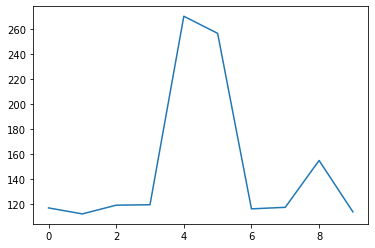

Training step : 212750
Training step : 213000
Training step : 213250
Training step : 213500
Training step : 213750
Training step : 214000
Training step : 214250
Training step : 214500
Training step : 214750
Training step : 215000
Best agent score : 270.355
Best agent step : 100000
total step : 860000


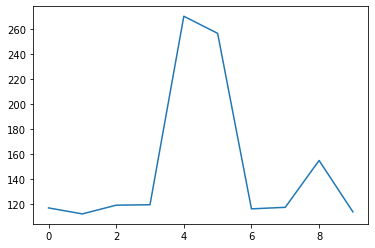

Training step : 215250
Training step : 215500
Training step : 215750
Training step : 216000
Training step : 216250
Training step : 216500
Training step : 216750
Training step : 217000
Training step : 217250
Training step : 217500
Best agent score : 270.355
Best agent step : 100000
total step : 870000


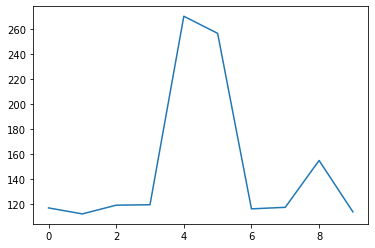

Training step : 217750
Training step : 218000
Training step : 218250
Training step : 218500
Training step : 218750
Training step : 219000
Training step : 219250
Training step : 219500
Training step : 219750
test_save
test_save finished
Training step : 220000
Best agent score : 270.355
Best agent step : 100000
total step : 880000


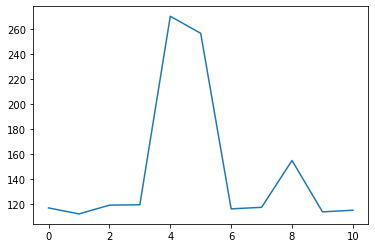

Training step : 220250
Training step : 220500
Training step : 220750
Training step : 221000
Training step : 221250
Training step : 221500
Training step : 221750
Training step : 222000
Training step : 222250
Training step : 222500
Best agent score : 270.355
Best agent step : 100000
total step : 890000


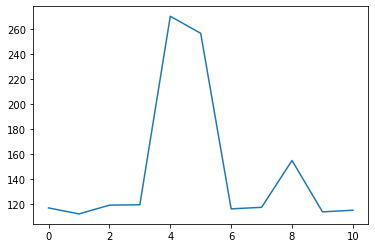

Training step : 222750
Training step : 223000
Training step : 223250
Training step : 223500
Training step : 223750
Training step : 224000
Training step : 224250
Training step : 224500
Training step : 224750
Training step : 225000
Best agent score : 270.355
Best agent step : 100000
total step : 900000


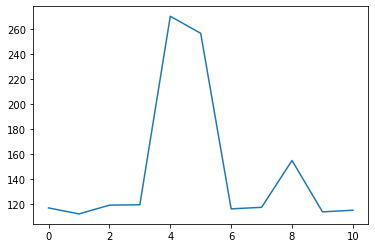

Training step : 225250
Training step : 225500
Training step : 225750
Training step : 226000
Training step : 226250
Training step : 226500
Training step : 226750
Training step : 227000
Training step : 227250
Training step : 227500
Best agent score : 270.355
Best agent step : 100000
total step : 910000


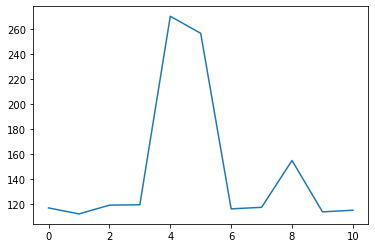

Training step : 227750
Training step : 228000
Training step : 228250
Training step : 228500
Training step : 228750
Training step : 229000
Training step : 229250
Training step : 229500
Training step : 229750
Training step : 230000
Best agent score : 270.355
Best agent step : 100000
total step : 920000


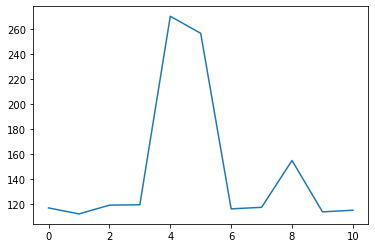

Training step : 230250
Training step : 230500
Training step : 230750
Training step : 231000
Training step : 231250
Training step : 231500
Training step : 231750
Training step : 232000
Training step : 232250
Training step : 232500
Best agent score : 270.355
Best agent step : 100000
total step : 930000


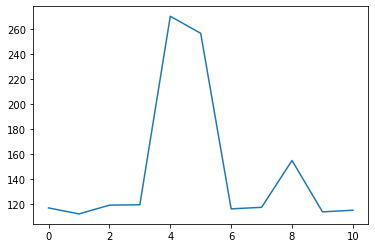

Training step : 232750
Training step : 233000
Training step : 233250
Training step : 233500
Training step : 233750
Training step : 234000
Training step : 234250
Training step : 234500
Training step : 234750
Training step : 235000
Best agent score : 270.355
Best agent step : 100000
total step : 940000


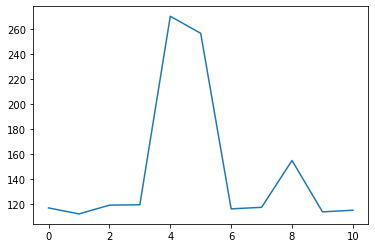

Training step : 235250
Training step : 235500
Training step : 235750
Training step : 236000
Training step : 236250
Training step : 236500
Training step : 236750
Training step : 237000
Training step : 237250
Training step : 237500
Best agent score : 270.355
Best agent step : 100000
total step : 950000


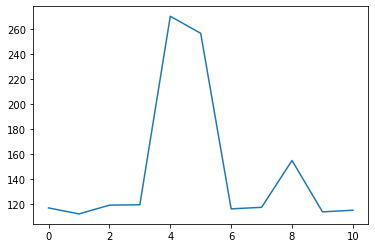

Training step : 237750
Training step : 238000
Training step : 238250
Training step : 238500
Training step : 238750
Training step : 239000
Training step : 239250
Training step : 239500
Training step : 239750
test_save
test_save finished
Training step : 240000
Best agent score : 270.355
Best agent step : 100000
total step : 960000


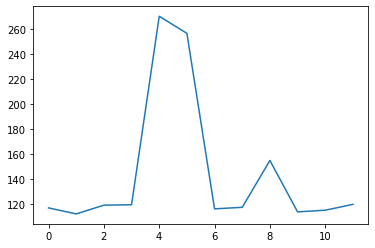

Training step : 240250
Training step : 240500
Training step : 240750
Training step : 241000
Training step : 241250
Training step : 241500
Training step : 241750
Training step : 242000
Training step : 242250
Training step : 242500
Best agent score : 270.355
Best agent step : 100000
total step : 970000


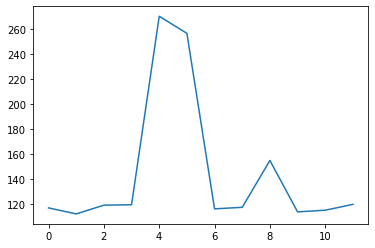

Training step : 242750
Training step : 243000
Training step : 243250
Training step : 243500
Training step : 243750
Training step : 244000
Training step : 244250
Training step : 244500
Training step : 244750
Training step : 245000
Best agent score : 270.355
Best agent step : 100000
total step : 980000


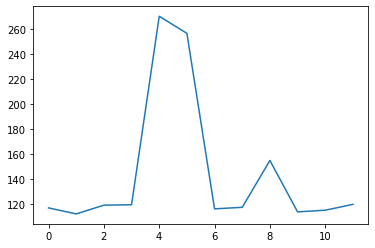

Training step : 245250
Training step : 245500
Training step : 245750
Training step : 246000
Training step : 246250
Training step : 246500
Training step : 246750
Training step : 247000
Training step : 247250
Training step : 247500
Best agent score : 270.355
Best agent step : 100000
total step : 990000


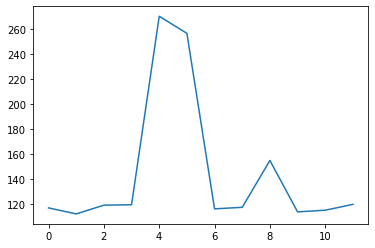

Training step : 247750
Training step : 248000
Training step : 248250
Training step : 248500
Training step : 248750
Training step : 249000
Training step : 249250
Training step : 249500
Training step : 249750
Training step : 250000
Best agent score : 270.355
Best agent step : 100000
total step : 1000000


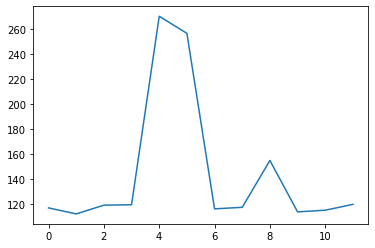

Training step : 250250
Training step : 250500
Training step : 250750
Training step : 251000
Training step : 251250
Training step : 251500
Training step : 251750
Training step : 252000
Training step : 252250
Training step : 252500
Best agent score : 270.355
Best agent step : 100000
total step : 1010000


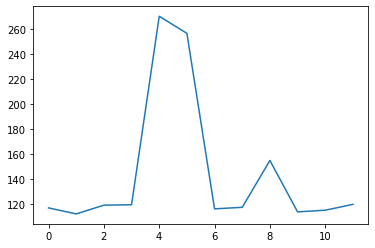

Training step : 252750
Training step : 253000
Training step : 253250
Training step : 253500
Training step : 253750
Training step : 254000
Training step : 254250
Training step : 254500
Training step : 254750
Training step : 255000
Best agent score : 270.355
Best agent step : 100000
total step : 1020000


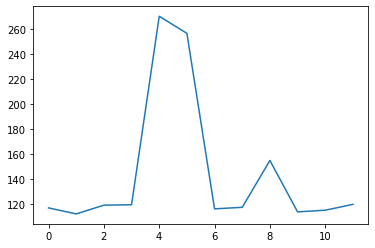

Training step : 255250
Training step : 255500
Training step : 255750
Training step : 256000
Training step : 256250
Training step : 256500
Training step : 256750
Training step : 257000
Training step : 257250
Training step : 257500
Best agent score : 270.355
Best agent step : 100000
total step : 1030000


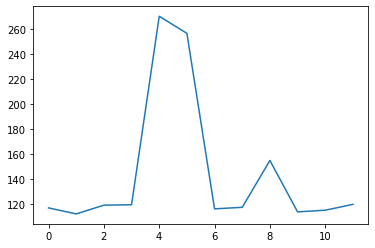

Training step : 257750
Training step : 258000
Training step : 258250
Training step : 258500
Training step : 258750
Training step : 259000
Training step : 259250
Training step : 259500
Training step : 259750
test_save
test_save finished
Training step : 260000
Best agent score : 270.355
Best agent step : 100000
total step : 1040000


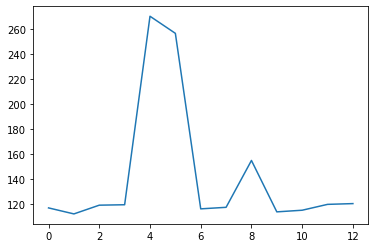

Training step : 260250
Training step : 260500
Training step : 260750
Training step : 261000
Training step : 261250
Training step : 261500
Training step : 261750
Training step : 262000
Training step : 262250
Training step : 262500
Best agent score : 270.355
Best agent step : 100000
total step : 1050000


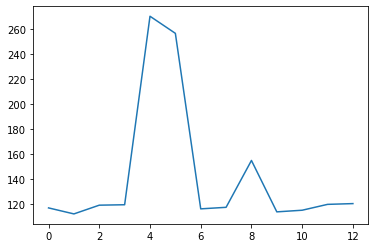

Training step : 262750
Training step : 263000
Training step : 263250
Training step : 263500
Training step : 263750
Training step : 264000
Training step : 264250
Training step : 264500
Training step : 264750
Training step : 265000
Best agent score : 270.355
Best agent step : 100000
total step : 1060000


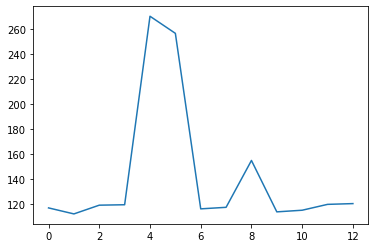

Training step : 265250
Training step : 265500
Training step : 265750
Training step : 266000
Training step : 266250
Training step : 266500
Training step : 266750
Training step : 267000
Training step : 267250
Training step : 267500
Best agent score : 270.355
Best agent step : 100000
total step : 1070000


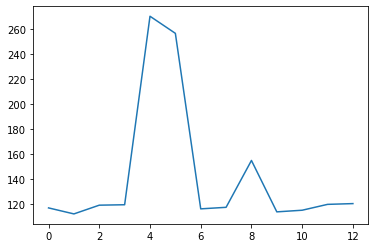

Training step : 267750
Training step : 268000
Training step : 268250
Training step : 268500
Training step : 268750
Training step : 269000
Training step : 269250
Training step : 269500
Training step : 269750
Training step : 270000
Best agent score : 270.355
Best agent step : 100000
total step : 1080000


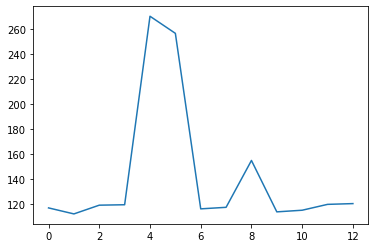

Training step : 270250
Training step : 270500
Training step : 270750
Training step : 271000
Training step : 271250
Training step : 271500
Training step : 271750
Training step : 272000
Training step : 272250
Training step : 272500
Best agent score : 270.355
Best agent step : 100000
total step : 1090000


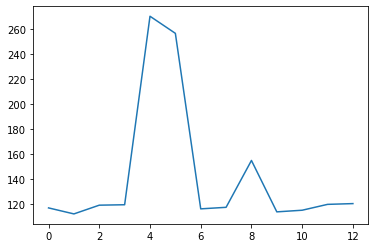

Training step : 272750
Training step : 273000
Training step : 273250
Training step : 273500
Training step : 273750
Training step : 274000
Training step : 274250
Training step : 274500
Training step : 274750
Training step : 275000
Best agent score : 270.355
Best agent step : 100000
total step : 1100000


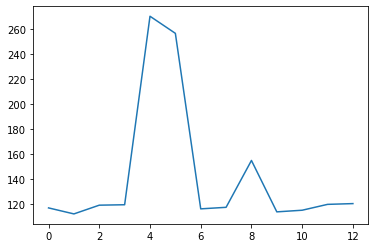

Training step : 275250
Training step : 275500
Training step : 275750
Training step : 276000
Training step : 276250
Training step : 276500
Training step : 276750
Training step : 277000
Training step : 277250
Training step : 277500
Best agent score : 270.355
Best agent step : 100000
total step : 1110000


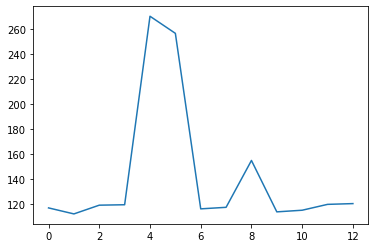

Training step : 277750
Training step : 278000
Training step : 278250
Training step : 278500
Training step : 278750
Training step : 279000
Training step : 279250
Training step : 279500
Training step : 279750
test_save
test_save finished
Training step : 280000
Best agent score : 270.355
Best agent step : 100000
total step : 1120000


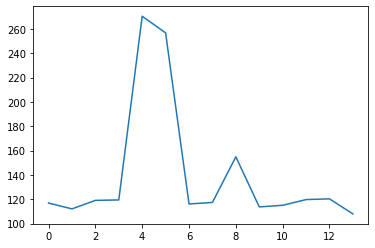

Training step : 280250
Training step : 280500
Training step : 280750
Training step : 281000
Training step : 281250
Training step : 281500
Training step : 281750
Training step : 282000
Training step : 282250
Training step : 282500
Best agent score : 270.355
Best agent step : 100000
total step : 1130000


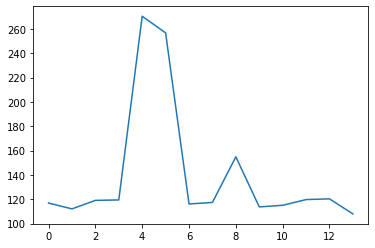

Training step : 282750
Training step : 283000
Training step : 283250
Training step : 283500
Training step : 283750
Training step : 284000
Training step : 284250
Training step : 284500
Training step : 284750
Training step : 285000
Best agent score : 270.355
Best agent step : 100000
total step : 1140000


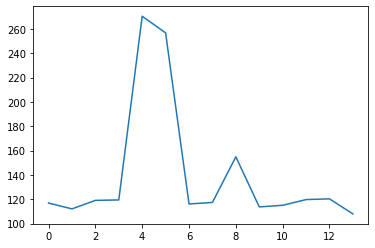

Training step : 285250
Training step : 285500
Training step : 285750
Training step : 286000
Training step : 286250
Training step : 286500
Training step : 286750
Training step : 287000
Training step : 287250
Training step : 287500
Best agent score : 270.355
Best agent step : 100000
total step : 1150000


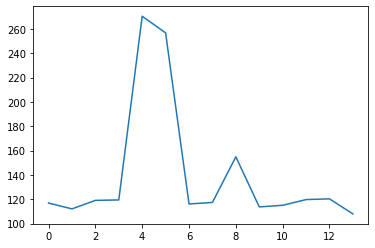

Training step : 287750
Training step : 288000
Training step : 288250
Training step : 288500
Training step : 288750
Training step : 289000
Training step : 289250
Training step : 289500
Training step : 289750
Training step : 290000
Best agent score : 270.355
Best agent step : 100000
total step : 1160000


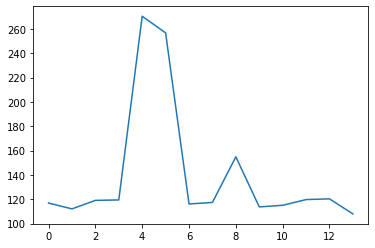

Training step : 290250
Training step : 290500
Training step : 290750
Training step : 291000
Training step : 291250
Training step : 291500
Training step : 291750
Training step : 292000
Training step : 292250
Training step : 292500
Best agent score : 270.355
Best agent step : 100000
total step : 1170000


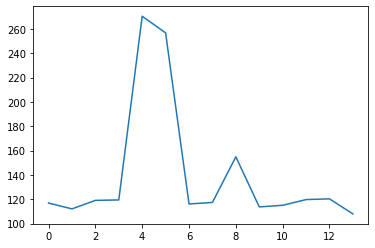

Training step : 292750
Training step : 293000
Training step : 293250
Training step : 293500
Training step : 293750
Training step : 294000
Training step : 294250
Training step : 294500
Training step : 294750
Training step : 295000
Best agent score : 270.355
Best agent step : 100000
total step : 1180000


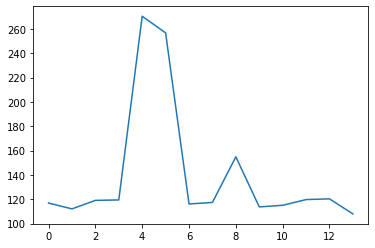

Training step : 295250
Training step : 295500
Training step : 295750
Training step : 296000
Training step : 296250
Training step : 296500
Training step : 296750
Training step : 297000
Training step : 297250
Training step : 297500
Best agent score : 270.355
Best agent step : 100000
total step : 1190000


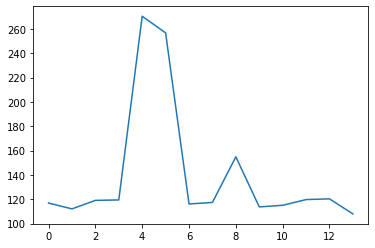

Training step : 297750
Training step : 298000
Training step : 298250
Training step : 298500
Training step : 298750
Training step : 299000
Training step : 299250
Training step : 299500
Training step : 299750
test_save
test_save finished
Training step : 300000
Best agent score : 270.355
Best agent step : 100000
total step : 1200000


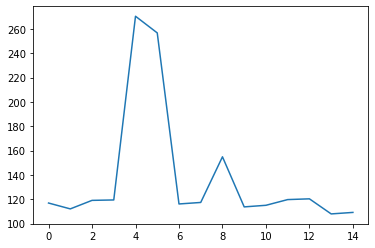

Training step : 300250
Training step : 300500
Training step : 300750
Training step : 301000
Training step : 301250
Training step : 301500
Training step : 301750
Training step : 302000
Training step : 302250
Training step : 302500
Best agent score : 270.355
Best agent step : 100000
total step : 1210000


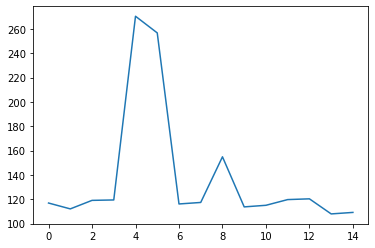

Training step : 302750
Training step : 303000
Training step : 303250
Training step : 303500
Training step : 303750
Training step : 304000
Training step : 304250
Training step : 304500
Training step : 304750
Training step : 305000
Best agent score : 270.355
Best agent step : 100000
total step : 1220000


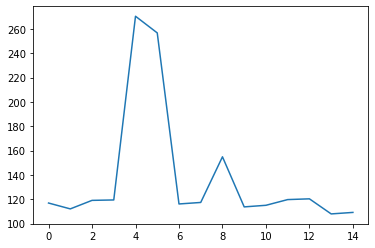

Training step : 305250
Training step : 305500
Training step : 305750
Training step : 306000
Training step : 306250
Training step : 306500
Training step : 306750
Training step : 307000
Training step : 307250
Training step : 307500
Best agent score : 270.355
Best agent step : 100000
total step : 1230000


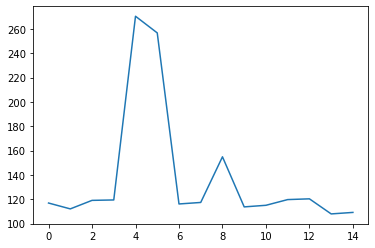

Training step : 307750
Training step : 308000
Training step : 308250
Training step : 308500
Training step : 308750
Training step : 309000
Training step : 309250
Training step : 309500
Training step : 309750
Training step : 310000
Best agent score : 270.355
Best agent step : 100000
total step : 1240000


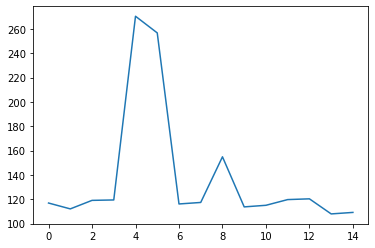

Training step : 310250
Training step : 310500
Training step : 310750
Training step : 311000
Training step : 311250
Training step : 311500
Training step : 311750
Training step : 312000
Training step : 312250
Training step : 312500
Best agent score : 270.355
Best agent step : 100000
total step : 1250000


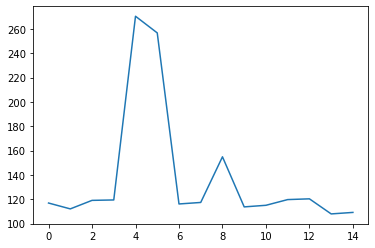

Training step : 312750
Training step : 313000
Training step : 313250
Training step : 313500
Training step : 313750
Training step : 314000
Training step : 314250
Training step : 314500
Training step : 314750
Training step : 315000
Best agent score : 270.355
Best agent step : 100000
total step : 1260000


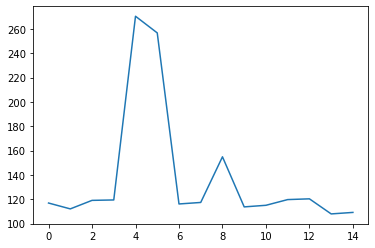

Training step : 315250
Training step : 315500
Training step : 315750
Training step : 316000
Training step : 316250
Training step : 316500
Training step : 316750
Training step : 317000
Training step : 317250
Training step : 317500
Best agent score : 270.355
Best agent step : 100000
total step : 1270000


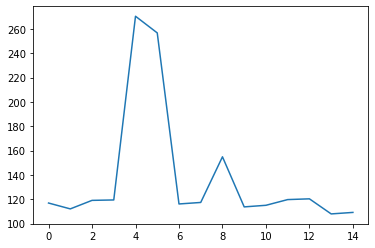

Training step : 317750
Training step : 318000
Training step : 318250
Training step : 318500
Training step : 318750
Training step : 319000
Training step : 319250
Training step : 319500
Training step : 319750
test_save
test_save finished
Training step : 320000
Best agent score : 270.355
Best agent step : 100000
total step : 1280000


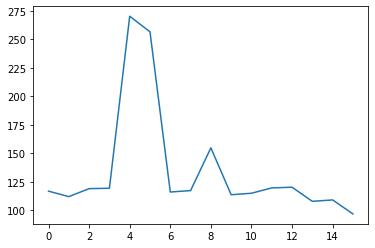

Training step : 320250
Training step : 320500
Training step : 320750
Training step : 321000
Training step : 321250
Training step : 321500
Training step : 321750
Training step : 322000
Training step : 322250
Training step : 322500
Best agent score : 270.355
Best agent step : 100000
total step : 1290000


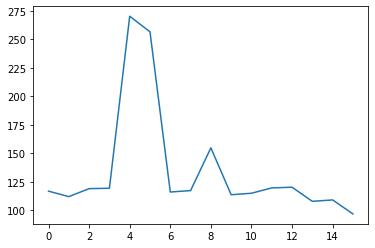

Training step : 322750
Training step : 323000
Training step : 323250
Training step : 323500
Training step : 323750
Training step : 324000
Training step : 324250
Training step : 324500
Training step : 324750
Training step : 325000
Best agent score : 270.355
Best agent step : 100000
total step : 1300000


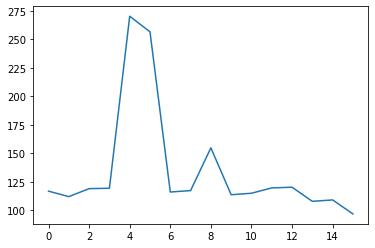

Training step : 325250
Training step : 325500
Training step : 325750
Training step : 326000
Training step : 326250
Training step : 326500
Training step : 326750
Training step : 327000
Training step : 327250
Training step : 327500
Best agent score : 270.355
Best agent step : 100000
total step : 1310000


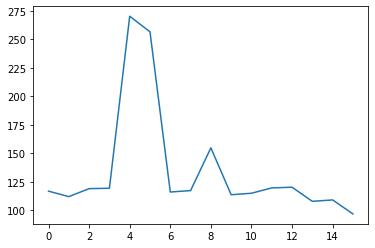

Training step : 327750
Training step : 328000
Training step : 328250
Training step : 328500
Training step : 328750
Training step : 329000
Training step : 329250
Training step : 329500
Training step : 329750
Training step : 330000
Best agent score : 270.355
Best agent step : 100000
total step : 1320000


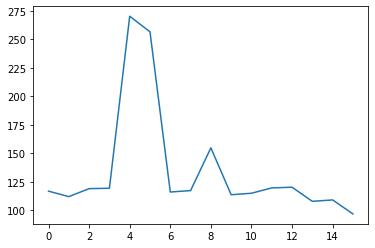

Training step : 330250
Training step : 330500
Training step : 330750
Training step : 331000
Training step : 331250
Training step : 331500
Training step : 331750
Training step : 332000
Training step : 332250
Training step : 332500
Best agent score : 270.355
Best agent step : 100000
total step : 1330000


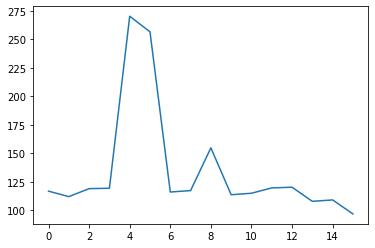

Training step : 332750
Training step : 333000
Training step : 333250
Training step : 333500
Training step : 333750
Training step : 334000
Training step : 334250
Training step : 334500
Training step : 334750
Training step : 335000
Best agent score : 270.355
Best agent step : 100000
total step : 1340000


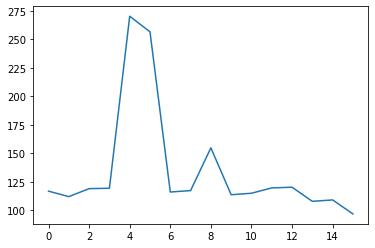

Training step : 335250
Training step : 335500
Training step : 335750
Training step : 336000
Training step : 336250
Training step : 336500
Training step : 336750
Training step : 337000
Training step : 337250
Training step : 337500
Best agent score : 270.355
Best agent step : 100000
total step : 1350000


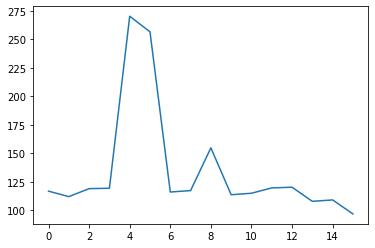

Training step : 337750
Training step : 338000
Training step : 338250
Training step : 338500
Training step : 338750
Training step : 339000
Training step : 339250
Training step : 339500
Training step : 339750
test_save
test_save finished
Training step : 340000
Best agent score : 270.355
Best agent step : 100000
total step : 1360000


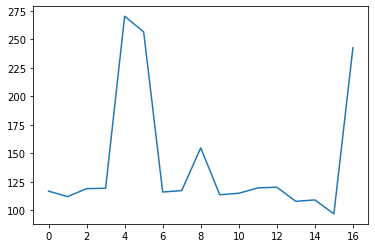

Training step : 340250
Training step : 340500
Training step : 340750
Training step : 341000
Training step : 341250
Training step : 341500
Training step : 341750
Training step : 342000
Training step : 342250
Training step : 342500
Best agent score : 270.355
Best agent step : 100000
total step : 1370000


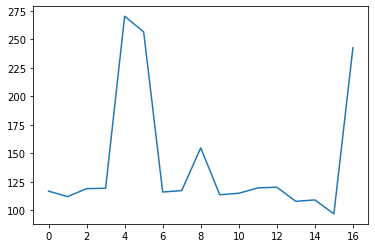

Training step : 342750
Training step : 343000
Training step : 343250
Training step : 343500
Training step : 343750
Training step : 344000
Training step : 344250
Training step : 344500
Training step : 344750
Training step : 345000
Best agent score : 270.355
Best agent step : 100000
total step : 1380000


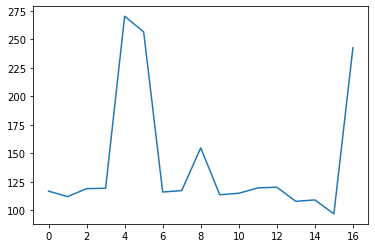

Training step : 345250
Training step : 345500
Training step : 345750
Training step : 346000
Training step : 346250
Training step : 346500
Training step : 346750
Training step : 347000
Training step : 347250
Training step : 347500
Best agent score : 270.355
Best agent step : 100000
total step : 1390000


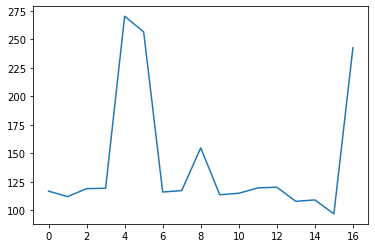

Training step : 347750
Training step : 348000
Training step : 348250
Training step : 348500
Training step : 348750
Training step : 349000
Training step : 349250
Training step : 349500
Training step : 349750
Training step : 350000
Best agent score : 270.355
Best agent step : 100000
total step : 1400000


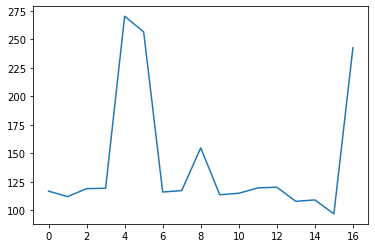

Training step : 350250
Training step : 350500
Training step : 350750
Training step : 351000
Training step : 351250
Training step : 351500
Training step : 351750
Training step : 352000
Training step : 352250
Training step : 352500
Best agent score : 270.355
Best agent step : 100000
total step : 1410000


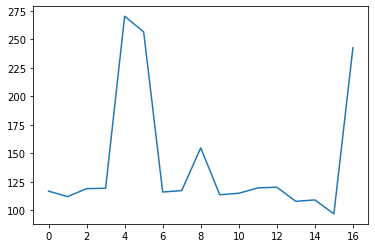

Training step : 352750
Training step : 353000
Training step : 353250
Training step : 353500
Training step : 353750
Training step : 354000
Training step : 354250
Training step : 354500
Training step : 354750
Training step : 355000
Best agent score : 270.355
Best agent step : 100000
total step : 1420000


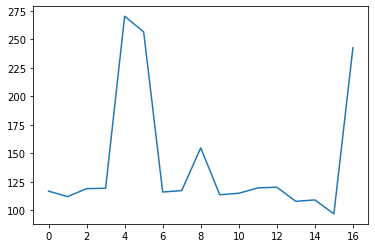

Training step : 355250
Training step : 355500
Training step : 355750
Training step : 356000
Training step : 356250
Training step : 356500
Training step : 356750
Training step : 357000
Training step : 357250
Training step : 357500
Best agent score : 270.355
Best agent step : 100000
total step : 1430000


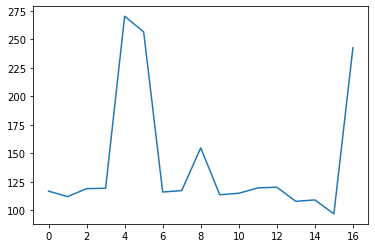

Training step : 357750
Training step : 358000
Training step : 358250
Training step : 358500
Training step : 358750
Training step : 359000
Training step : 359250
Training step : 359500
Training step : 359750
test_save
test_save finished
Training step : 360000
Best agent score : 270.355
Best agent step : 100000
total step : 1440000


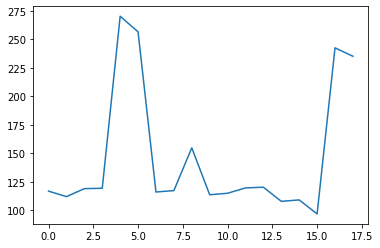

Training step : 360250
Training step : 360500
Training step : 360750
Training step : 361000
Training step : 361250
Training step : 361500
Training step : 361750
Training step : 362000
Training step : 362250
Training step : 362500
Best agent score : 270.355
Best agent step : 100000
total step : 1450000


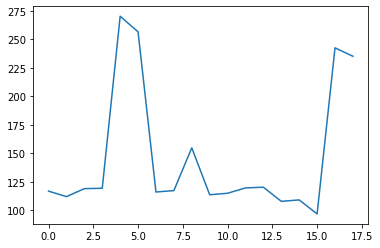

Training step : 362750
Training step : 363000
Training step : 363250
Training step : 363500
Training step : 363750
Training step : 364000
Training step : 364250
Training step : 364500
Training step : 364750
Training step : 365000
Best agent score : 270.355
Best agent step : 100000
total step : 1460000


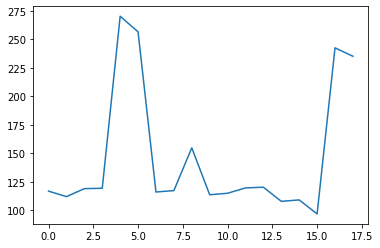

Training step : 365250
Training step : 365500
Training step : 365750
Training step : 366000
Training step : 366250
Training step : 366500
Training step : 366750
Training step : 367000
Training step : 367250
Training step : 367500
Best agent score : 270.355
Best agent step : 100000
total step : 1470000


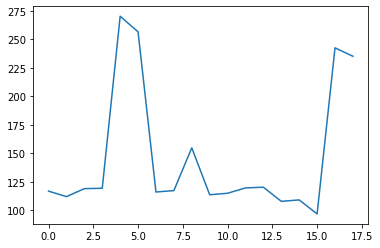

Training step : 367750
Training step : 368000
Training step : 368250
Training step : 368500
Training step : 368750
Training step : 369000
Training step : 369250
Training step : 369500
Training step : 369750
Training step : 370000
Best agent score : 270.355
Best agent step : 100000
total step : 1480000


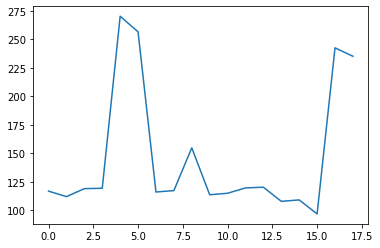

Training step : 370250
Training step : 370500
Training step : 370750
Training step : 371000
Training step : 371250
Training step : 371500
Training step : 371750
Training step : 372000
Training step : 372250
Training step : 372500
Best agent score : 270.355
Best agent step : 100000
total step : 1490000


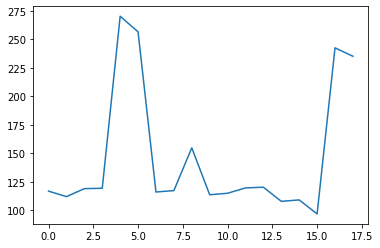

Training step : 372750
Training step : 373000
Training step : 373250
Training step : 373500
Training step : 373750
Training step : 374000
Training step : 374250
Training step : 374500
Training step : 374750
Training step : 375000
Best agent score : 270.355
Best agent step : 100000
total step : 1500000


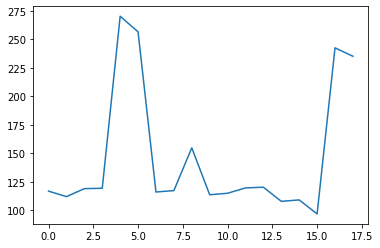

Training step : 375250
Training step : 375500
Training step : 375750
Training step : 376000
Training step : 376250
Training step : 376500
Training step : 376750
Training step : 377000
Training step : 377250
Training step : 377500
Best agent score : 270.355
Best agent step : 100000
total step : 1510000


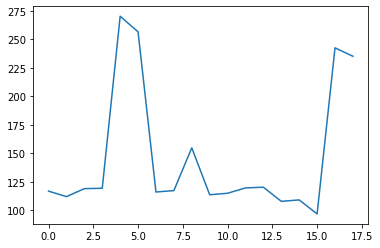

Training step : 377750
Training step : 378000
Training step : 378250
Training step : 378500
Training step : 378750
Training step : 379000
Training step : 379250
Training step : 379500
Training step : 379750
test_save
test_save finished
Training step : 380000
Best agent score : 270.355
Best agent step : 100000
total step : 1520000


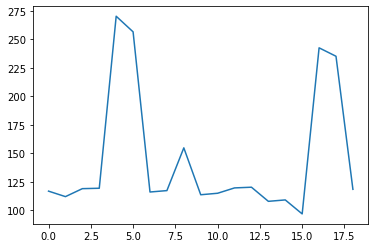

Training step : 380250
Training step : 380500
Training step : 380750
Training step : 381000
Training step : 381250
Training step : 381500
Training step : 381750
Training step : 382000
Training step : 382250
Training step : 382500
Best agent score : 270.355
Best agent step : 100000
total step : 1530000


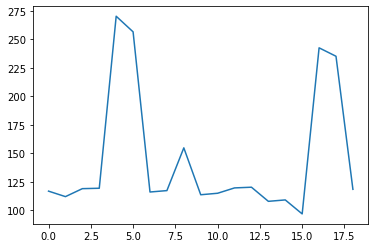

Training step : 382750
Training step : 383000
Training step : 383250
Training step : 383500
Training step : 383750
Training step : 384000
Training step : 384250
Training step : 384500
Training step : 384750
Training step : 385000
Best agent score : 270.355
Best agent step : 100000
total step : 1540000


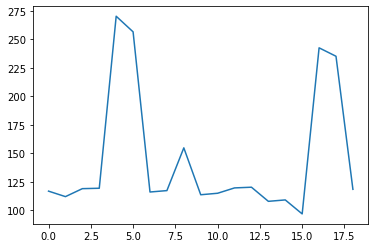

Training step : 385250
Training step : 385500
Training step : 385750
Training step : 386000
Training step : 386250
Training step : 386500
Training step : 386750
Training step : 387000
Training step : 387250
Training step : 387500
Best agent score : 270.355
Best agent step : 100000
total step : 1550000


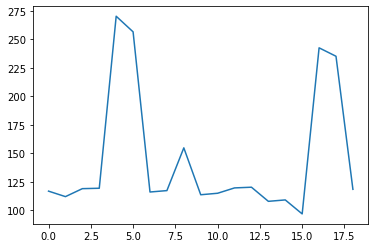

Training step : 387750
Training step : 388000
Training step : 388250
Training step : 388500
Training step : 388750
Training step : 389000
Training step : 389250
Training step : 389500
Training step : 389750
Training step : 390000
Best agent score : 270.355
Best agent step : 100000
total step : 1560000


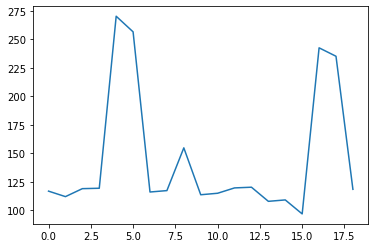

Training step : 390250
Training step : 390500
Training step : 390750
Training step : 391000
Training step : 391250
Training step : 391500
Training step : 391750
Training step : 392000
Training step : 392250
Training step : 392500
Best agent score : 270.355
Best agent step : 100000
total step : 1570000


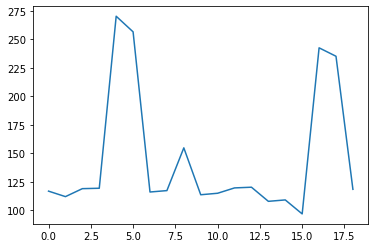

Training step : 392750
Training step : 393000
Training step : 393250
Training step : 393500
Training step : 393750
Training step : 394000
Training step : 394250
Training step : 394500
Training step : 394750
Training step : 395000
Best agent score : 270.355
Best agent step : 100000
total step : 1580000


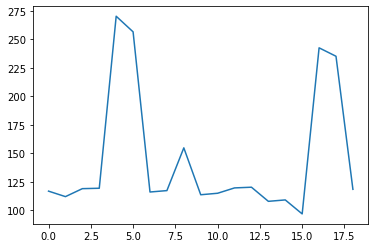

Training step : 395250
Training step : 395500
Training step : 395750
Training step : 396000
Training step : 396250
Training step : 396500
Training step : 396750
Training step : 397000
Training step : 397250
Training step : 397500
Best agent score : 270.355
Best agent step : 100000
total step : 1590000


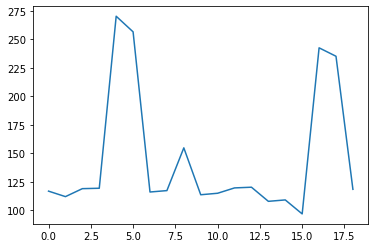

Training step : 397750
Training step : 398000
Training step : 398250
Training step : 398500
Training step : 398750
Training step : 399000
Training step : 399250
Training step : 399500
Training step : 399750
test_save
test_save finished
Training step : 400000
Best agent score : 270.355
Best agent step : 100000
total step : 1600000


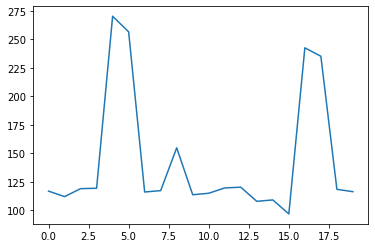

Training step : 400250
Training step : 400500
Training step : 400750
Training step : 401000
Training step : 401250
Training step : 401500
Training step : 401750
Training step : 402000
Training step : 402250
Training step : 402500
Best agent score : 270.355
Best agent step : 100000
total step : 1610000


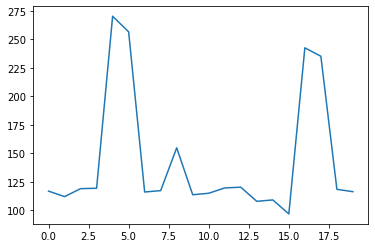

Training step : 402750
Training step : 403000
Training step : 403250
Training step : 403500
Training step : 403750
Training step : 404000
Training step : 404250
Training step : 404500
Training step : 404750
Training step : 405000
Best agent score : 270.355
Best agent step : 100000
total step : 1620000


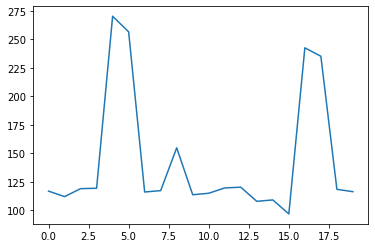

Training step : 405250
Training step : 405500
Training step : 405750
Training step : 406000
Training step : 406250
Training step : 406500
Training step : 406750
Training step : 407000
Training step : 407250
Training step : 407500
Best agent score : 270.355
Best agent step : 100000
total step : 1630000


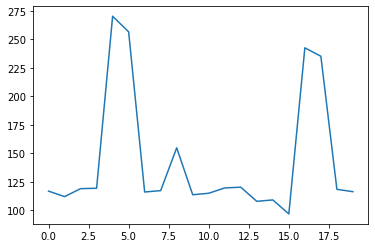

Training step : 407750
Training step : 408000
Training step : 408250
Training step : 408500
Training step : 408750
Training step : 409000
Training step : 409250
Training step : 409500
Training step : 409750
Training step : 410000
Best agent score : 270.355
Best agent step : 100000
total step : 1640000


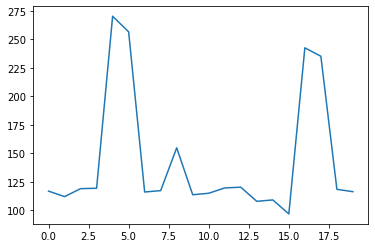

Training step : 410250
Training step : 410500
Training step : 410750
Training step : 411000
Training step : 411250
Training step : 411500
Training step : 411750
Training step : 412000
Training step : 412250
Training step : 412500
Best agent score : 270.355
Best agent step : 100000
total step : 1650000


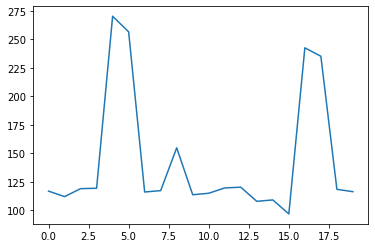

Training step : 412750
Training step : 413000
Training step : 413250
Training step : 413500
Training step : 413750
Training step : 414000
Training step : 414250
Training step : 414500
Training step : 414750
Training step : 415000
Best agent score : 270.355
Best agent step : 100000
total step : 1660000


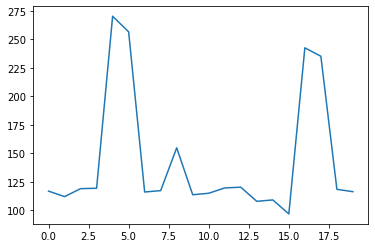

Training step : 415250
Training step : 415500
Training step : 415750
Training step : 416000
Training step : 416250
Training step : 416500
Training step : 416750
Training step : 417000
Training step : 417250
Training step : 417500
Best agent score : 270.355
Best agent step : 100000
total step : 1670000


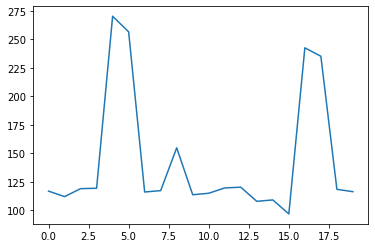

Training step : 417750
Training step : 418000
Training step : 418250
Training step : 418500
Training step : 418750
Training step : 419000
Training step : 419250
Training step : 419500
Training step : 419750
test_save
Best agent saved, score : 273.775
test_save finished
Training step : 420000
Best agent score : 273.775
Best agent step : 420000
total step : 1680000


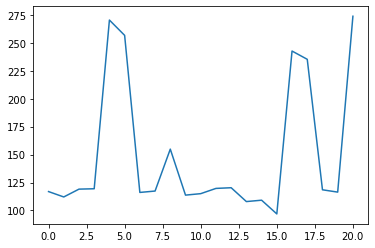

Training step : 420250
Training step : 420500
Training step : 420750
Training step : 421000
Training step : 421250
Training step : 421500
Training step : 421750
Training step : 422000
Training step : 422250
Training step : 422500
Best agent score : 273.775
Best agent step : 420000
total step : 1690000


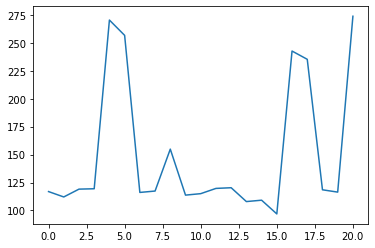

Training step : 422750
Training step : 423000


In [ ]:
#Main loop

state = env.reset()
last_state = state
last_action = 0
done = False
reward = 0

while agent.current_training_step < training_steps :
    action = agent.action_train(last_state, last_action,state, reward, done)
    last_state = state
    last_action = action
    
    if not done:
        state, reward, done, _ = env.step(action)
    else :
        state = env.reset()
        reward = 0
        done = False
        
    if agent.total_steps % (evaluate_steps*train_steps) == 0 :
        agent.test_save()
        
    if agent.total_steps % 1000 == 0:
        print("Training step : " + str(agent.current_training_step))
        
    if agent.total_steps % 10000 == 0:
        agent.print_data()